### Imports and Definition of Constants

In [1]:
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, RandomSampler
from resnest.torch import resnest50
from torch import nn
from torchvision import transforms
from sklearn.metrics import label_ranking_average_precision_score as lrap

import numpy as np
import pandas as pd
import soundfile as sf
import librosa
import librosa.display
import random
from PIL import Image

import io

import matplotlib.pyplot as plt
import os
import csv

import sklearn
from sklearn import model_selection

# idea for seeding from https://www.kaggle.com/code/fffrrt/all-in-one-rfcx-baseline-for-beginners
rng_seed = 1234
random.seed(rng_seed)
np.random.seed(rng_seed)
os.environ['PYTHONHASHSEED'] = str(rng_seed)
torch.manual_seed(rng_seed)
torch.cuda.manual_seed(rng_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

num_species = 24
batch_size = 64

fft = 2048
hop = 512 
# According to research, standard sampling bitrate is 48khz. Seen in discussion of kaggle competition as well. 
sr = 48000
length = 10*sr

data_path = '../Data/'

# should change this according to nvidia-smi output e.g. "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device('cuda')

tp = pd.read_csv(data_path + 'train_tp.csv')
fp = pd.read_csv(data_path + 'train_fp.csv')
fp['species_id'] = -fp['species_id']


### Separating Validation and Testing Data

In [2]:
df = pd.concat([tp,fp], ignore_index=True)

# creating dataframe of tp samples for validation, false positive samples used for training only

train_df = None
val_df = None

X = tp.drop('species_id', axis=1)
y = tp['species_id']

X_tp_train, X_tp_val, y_tp_train, y_tp_val = model_selection.train_test_split(X, y, random_state=rng_seed,\
                                                                              test_size=.2)

val_df = pd.concat([X_tp_val, y_tp_val], axis=1)

# train dataframe is the entire concatinated dataframe of tp and fp samples, excluding the tp samples separated for
# validation 
train_df = df[~df.index.isin(val_df.index)]


### Dataset Definition and Additional Preprocessing
Handles: <br>
   * Creation of label encoding, with separate label vector schema for false positive and true positive data
   * Loading of Melspectrograms
   * Transformations such as resizing and normalization of Melspectrograms

In [3]:
class RainforestDataset(Dataset):
    def __init__(self, df):
        
        self.data = []
        self.labels = []
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
                             
        for idx,row in df.iterrows():
            
            # custom label encoding to encourage the model to learn from false positive data and not be too confident
            # in predictions, as classes without presence in the fp label are given a small probability
            label = row['species_id']
            if label < 0:
                label_arr = np.full(24, .03)
                label_arr[label] = 0
            else:
                label_arr = np.full(24, .0)
                label_arr[label] = 1
            self.labels.append(label_arr)
            
            # reads preprocessed melspecs as RGB images
            image_mspec = Image.open('/tmp/librosa_images/' + str(idx) + "_melspec.png").convert('RGB')
        
            if idx < 5:
                image_mspec.show()
            self.data.append(image_mspec)
            
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (self.preprocess(self.data[idx]), torch.tensor(self.labels[idx]))

### Model Definition and Loading to GPU

In [4]:
# Model class definition 
model = resnest50(pretrained=False)

# ResNeST pretrained model should be uploaded to this path with the notebook, fetched from ResNeSt Github
model.load_state_dict(torch.load(data_path + 'resnest50-528c19ca.pth'))
model.eval()
model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, num_species)
)

# load model into GPU
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=.01, momentum=0.7, weight_decay=.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.4)

loss_function = nn.BCEWithLogitsLoss()
loss_function.to(device)

BCEWithLogitsLoss()

### Definition of Training and Validation Loops

In [5]:
def train_loop(train_loader, model, optimizer, loss_function):
    size = len(train_loader.dataset)
    for batch, (data, target) in enumerate(train_loader):

        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        pred = model(data)
        loss = loss_function(pred, target)
        
        # back propogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(data)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [6]:
def val_loop(val_loader, model, loss_function):
    size = len(val_loader.dataset)
    num_batches = len(val_loader)
    val_loss = 0
    label_ranked_precision = 0.0
    correct = 0
    
    with torch.no_grad():
        for batch, (data,target) in enumerate(val_loader):
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            
            pred = model(data)
            val_loss += loss_function(pred, target).item()
            
            pred, target = pred.cpu(), target.cpu()
            label_ranked_precision += lrap(target, pred)
            
            
            vals, preds = torch.max(pred, 1)
            vals, targets = torch.max(target, 1)
            for i in range(0, len(preds)):
                if preds[i] == targets[i]:
                    correct = correct + 1
            
            
    val_loss /= num_batches
    accuracy =  correct/size
    label_ranked_precision /= num_batches
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {val_loss:>8f}, LRAP: {label_ranked_precision:>.3f} \n")
    return label_ranked_precision
    


### Training

* Creates training and validation datasets
* Runs a training loop and a validation loop for each epoch, storing model with best validation according to LRAP

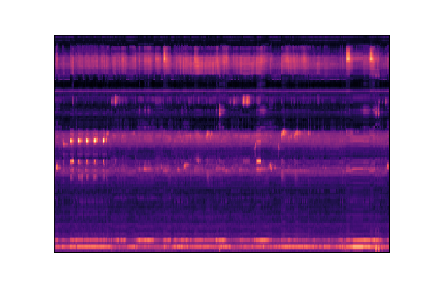

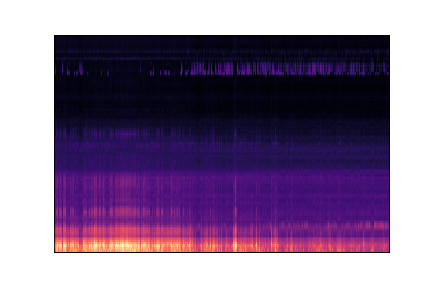

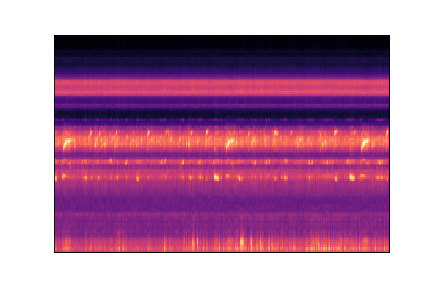

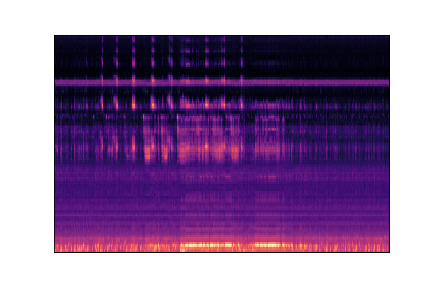

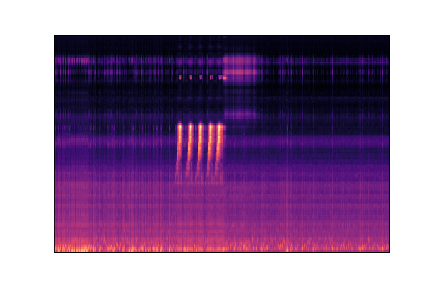

In [7]:
train_dataset = RainforestDataset(train_df)
val_dataset = RainforestDataset(val_df)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, sampler = RandomSampler(train_dataset))
val_loader = DataLoader(val_dataset, batch_size = batch_size, sampler = RandomSampler(val_dataset))

best_lrap = 0.0

epochs=25
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, optimizer, loss_function)
    val_lrap = val_loop(val_loader, model, loss_function)
    if(val_lrap > best_lrap):
        torch.save(model, "best_model_resnest.pth")
        best_lrap = val_lrap
    
print("Done!")


Epoch 1
-------------------------------
loss: 0.691688  [    0/ 8753]
loss: 0.159300  [  640/ 8753]
loss: 0.142615  [ 1280/ 8753]
loss: 0.140619  [ 1920/ 8753]
loss: 0.141590  [ 2560/ 8753]
loss: 0.137019  [ 3200/ 8753]
loss: 0.140793  [ 3840/ 8753]
loss: 0.137013  [ 4480/ 8753]
loss: 0.140790  [ 5120/ 8753]
loss: 0.136648  [ 5760/ 8753]
loss: 0.140335  [ 6400/ 8753]
loss: 0.137369  [ 7040/ 8753]
loss: 0.140527  [ 7680/ 8753]
loss: 0.140030  [ 8320/ 8753]
Test Error: 
 Accuracy: 4.5%, Avg loss: 0.178254, LRAP: 0.163 

Epoch 2
-------------------------------
loss: 0.139141  [    0/ 8753]
loss: 0.140276  [  640/ 8753]
loss: 0.140515  [ 1280/ 8753]
loss: 0.139287  [ 1920/ 8753]
loss: 0.136946  [ 2560/ 8753]
loss: 0.137488  [ 3200/ 8753]
loss: 0.141408  [ 3840/ 8753]
loss: 0.142225  [ 4480/ 8753]
loss: 0.139903  [ 5120/ 8753]
loss: 0.135778  [ 5760/ 8753]
loss: 0.137953  [ 6400/ 8753]
loss: 0.137328  [ 7040/ 8753]
loss: 0.139543  [ 7680/ 8753]
loss: 0.138713  [ 8320/ 8753]
Test Error: 
 Ac

### Submission Generation

* Loads in a stack of spectrograms that are spliced to meet time domain dimensions of training data 
    * Also used to match the 4-D batch-oriented input dimensions of the model
* Does the same transforms as the training and validation data

Sourced from https://www.kaggle.com/code/fffrrt/all-in-one-rfcx-baseline-for-beginners

In [ ]:
# Model class definition 
model = resnest50(pretrained=True)

model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, num_species)
)

model = torch.load('best_model_resnest.pth')
model.eval()


# load model into GPU
model = model.to(device)

    
preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

    
# Prediction loop
print('Starting prediction loop')
with open('submission.csv', 'w', newline='') as csvfile:
    submission_writer = csv.writer(csvfile, delimiter=',')
    submission_writer.writerow(['recording_id','s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11',
                               's12','s13','s14','s15','s16','s17','s18','s19','s20','s21','s22','s23'])
    
    test_files = os.listdir(data_path + 'test/') 
    print(len(test_files))
    
    # Reads in test spectrograms that have already been preprocessed in preprocessing notebook
    for i in range(len(test_files)):
        tensor_array = []
        for j in range(4):
            image_mspec = Image.open('/tmp/librosa_images/test/' + test_files[i][:-4] + '_' + str(j) + "_melspec.png").convert('RGB')
            preprocessed_mspec = preprocess(image_mspec).numpy()
            tensor_array.append(preprocessed_mspec)
        tensor_array = torch.tensor(tensor_array).to(device)
        
        with torch.no_grad():
            output = model(tensor_array)

        
        maxed_output = torch.max(output, dim=0)[0]
        maxed_output = maxed_output.cpu().detach()
        
        file_id = str.split(test_files[i], '.')[0]
        write_array = [file_id]
        
        for out in maxed_output:
            write_array.append(out.item())
    
        submission_writer.writerow(write_array)
        
        if i % 100 == 0 and i > 0:
            print('Predicted for ' + str(i) + ' of ' + str(len(test_files) + 1) + ' files')

print('Submission generated')